# Forcasting U.S. Retail Sales with ARIMA
### A Financial KPI Forecasting Project
**Author:** Damar Shipp Jr.

**Role:** Financial Analyst | U.S. Army Vet

___
## Executive Summary
##### This project focuses on forecasting U.S. retail sales(a key macroeconomic KPI); using ARIMA time series modeling. Retail sales data reflects consumer behavior and directly impacts financial forecasting, revenue projections, inventory management, and strategic planning.

##### As a data-driven Financial Analyst, my objective was to:
- Model historical retail sales patterns from 2014–2024
- Generate a forward-looking 24-month forecast
- Identify seasonality, trends, and macroeconomic implications
- Provide a repeatable, interpretable, and actionable analytics asset

##### The analysis leverages Python, pandas, statsmodels, and pmdarima — with a focus on accuracy, business relevance, and communication of insights.

______
## Data Overview

- **Source:** FRED (Federal Reserve Economic Data)
- **Series ID:** RSXFS – U.S. Retail & Food Services Sales (Seasonally Adjusted)
- **Frequency:** Monthly
- **Time Range:** 2014–2024
- **Metric:** Retail sales in millions USD

This dataset serves as a critical economic indicator which is used by analysts, policymakers, and financial strategists to assess consumer health and predict GDP movements.

## Load & View the Raw Data

##### The data is pulled using `pandas_datareader` directly from the FRED API. We inspect the structure, check for nulls, and confirm the time index.

*Key tasks:*
- Load data from FRED
- View tail/head
- Check time index and types
- Clean missing values if any

In [213]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [214]:
# Time range
start = datetime(2014, 1, 1)
end = datetime(2024, 12, 31)

In [215]:
# Pull U.S. Retail Sales from FRED
retail_sales = web.DataReader('RSXFS', 'fred', start, end)

In [216]:
# View the size of the data
retail_sales.shape

(132, 1)

In [217]:
# View U.S. Retail 
retail_sales.head()

,RSXFS
DATE,
2014-01-01,366684
2014-02-01,371335
2014-03-01,375285
2014-04-01,379432
2014-05-01,379787


In [218]:
# View U.S. Retail ending
retail_sales.tail()

,RSXFS
DATE,
2024-08-01,604173
2024-09-01,608701
2024-10-01,612570
2024-11-01,616833
2024-12-01,622396


In [219]:
# Check for Null Values
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2014-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RSXFS   132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


In [220]:
# View U.S. Retail Statistics
retail_sales.describe()

,RSXFS
count,132.000000
mean,473021.189394
std,83355.176958
min,366684.000000
25%,398288.250000
50%,438404.000000
75%,570460.500000
max,622396.000000


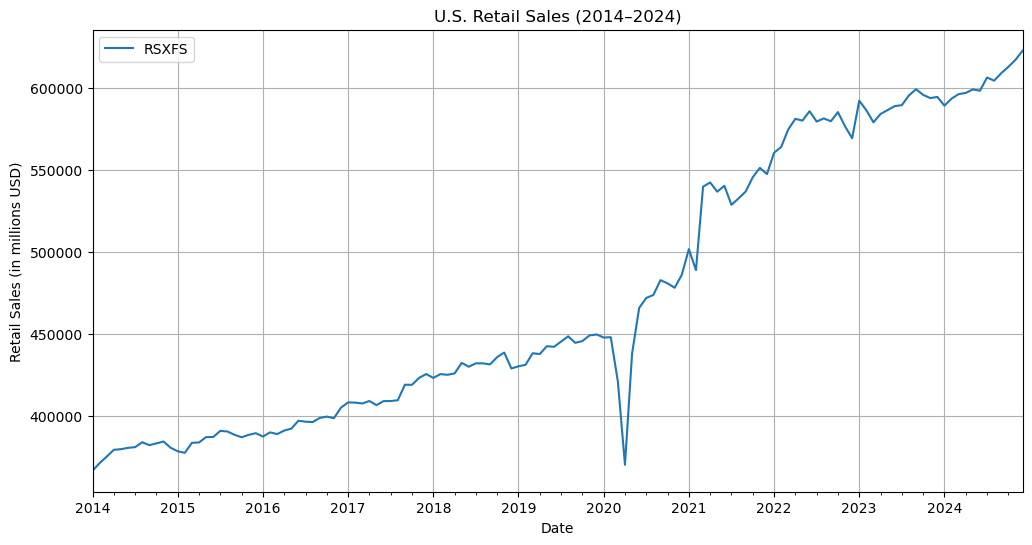

In [221]:
# Drop NAs and visualize
retail_sales.dropna(inplace=True)
retail_sales.plot(title='U.S. Retail Sales (2014–2024)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Retail Sales (in millions USD)')
plt.grid(True)
plt.show()

## Exploratory Data Analysis (EDA)
We analyze overall trends, seasonality, and anomalies in retail sales behavior.

#### A. Rolling Averages
- 3 and 6-month rolling averages to smooth volatility

#### B. Month-to-Month Deltas
- Change in sales to identify economic shocks (e.g. 2020 drop)

#### C. Seasonal Decomposition
- Breakdown of trend, seasonality, and residuals using additive model

#### These analyses lay the foundation for determining model fit and business interpretation.

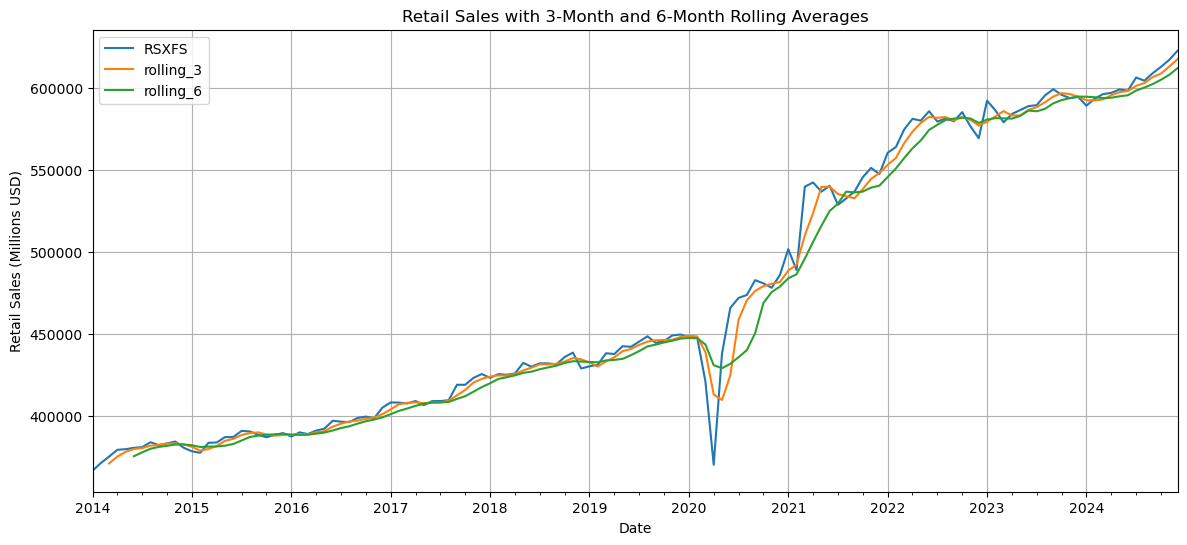

In [222]:
# View Rolling Averages To The Actual Price
retail_sales['rolling_3'] = retail_sales['RSXFS'].rolling(window=3).mean()
retail_sales['rolling_6'] = retail_sales['RSXFS'].rolling(window=6).mean()

retail_sales[['RSXFS', 'rolling_3', 'rolling_6']].plot(
    figsize=(14,6),
    title='Retail Sales with 3-Month and 6-Month Rolling Averages'
)
plt.xlabel("Date")
plt.ylabel("Retail Sales (Millions USD)")
plt.grid(True)
plt.show()

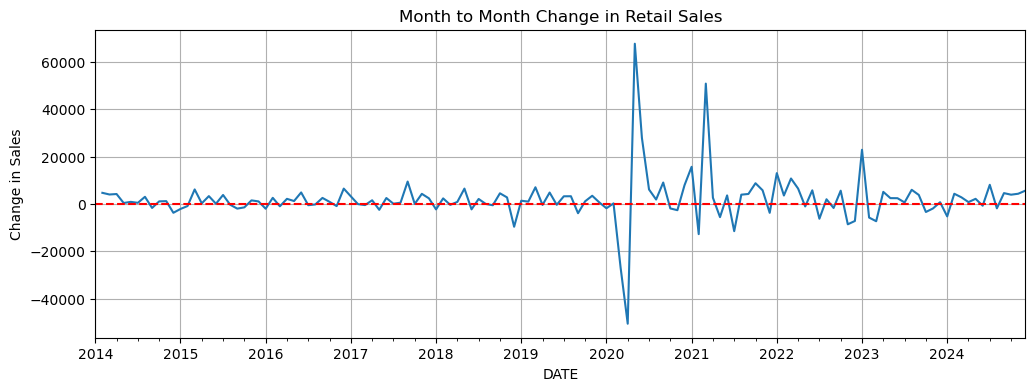

In [223]:
#Import seasonal decompose and View month to month
from statsmodels.tsa.seasonal import seasonal_decompose

retail_sales['change'] = retail_sales['RSXFS'].diff()

retail_sales['change'].plot(
    figsize=(12, 4),
    title='Month to Month Change in Retail Sales'
)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Change in Sales")
plt.grid(True)
plt.show()

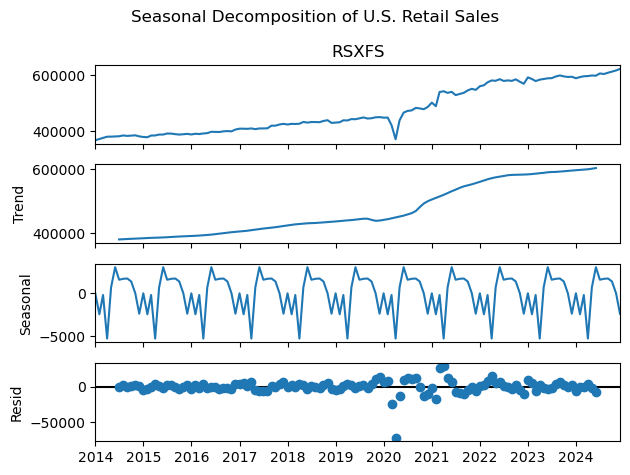

In [224]:
# View U.S. Retail Trend, Seasonality, Residuals
result = seasonal_decompose(retail_sales['RSXFS'], model='additive', period=12)
result.plot()
plt.suptitle('Seasonal Decomposition of U.S. Retail Sales')
plt.tight_layout()
plt.show()

## Stationarity Testing
Time series modeling assumes stationarity. We perform the Augmented Dickey-Fuller (ADF) test and apply first-order differencing where needed.

### Key Point:
- If p-value > 0.05, we difference the data once to stabilize trend

**(This step ensures that our ARIMA model will perform with statistical reliability.)**

In [225]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(retail_sales['RSXFS'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: 0.24372467994170124
p-value: 0.9746100686215233
Critical Value (1%): -3.486055829282407
Critical Value (5%): -2.8859430324074076
Critical Value (10%): -2.5797850694444446


#### Since the p-value is greater than 0.05 then it is not stationary.

In [226]:
# Create New Column For the first order differences
retail_sales['RSXFS_diff'] = retail_sales['RSXFS'].diff()
retail_sales.dropna(inplace=True)

In [227]:
# Run ADF Test
result_diff = adfuller(retail_sales['RSXFS_diff'])
print('Differenced ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

Differenced ADF Statistic: -2.973971463615431
p-value: 0.03739767514772892


#### Since the p-value is now less than 0.05 it is stationary.

## Model Fitting: ARIMA

We use `pmdarima.auto_arima()` to automatically tune ARIMA(p,d,q) parameters.

- **AR (p)**: Past values
- **I (d)**: Differencing to remove trend
- **MA (q)**: Past forecast errors

### Model selection criteria:
- AIC (Akaike Information Criterion)
- Error handling (e.g., auto-adjust for overfitting)

In [228]:
# Install pmdarima
# pip install pmdarima

In [229]:
# Import auto arima from the install
from pmdarima import auto_arima

# Run auto_arima on differenced data (skip if already stationary)
model = auto_arima(retail_sales['RSXFS'], 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   d=1,
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

print("AIC Score:", model.aic())
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2698.434, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2694.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2696.347, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2696.425, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2696.697, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.214 seconds
AIC Score: 2694.5432004026125


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1345.272
Date:                Sat, 24 May 2025   AIC                           2694.543
Time:                        11:28:39   BIC                           2700.216
Sample:                    06-01-2014   HQIC                          2696.848
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1918.8730   1008.729      1.902      0.057     -58.200    3895.946
sigma2        1.1e+08   4.61e+06     23.848      0.000    1.01e+08    1.19e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):              1968.23
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               5.16   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting 24-Month Retail Sales

We forecast future values and generate a confidence interval range to capture uncertainty.

### Outputs:
- Forecasted monthly sales (24 periods)
- 95% confidence intervals
- Future DatetimeIndex applied

### Why It Matters:
Retail, finance, and supply chain teams rely on these forecasts for resource allocation, risk management, and strategy development.

In [230]:
# Forecast
n_periods = 24
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

In [231]:
# View Predictions 
forecast.head()

2025-01-01    624314.873016
2025-02-01    626233.746032
2025-03-01    628152.619048
2025-04-01    630071.492063
2025-05-01    631990.365079
Freq: MS, dtype: float64

In [232]:
# Import numpy
import numpy as np

# Forecast
n_periods = 24
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Create future datetime index
last_date = retail_sales.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='m')

# Clean forecast DataFrame
forecast=np.array(forecast).reshape(-1)
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=future_dates)

forecast_df.head()

/var/folders/pk/z58dkjgn50153_74d2055v0r0000gn/T/ipykernel_27188/3982139949.py:10: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='m')


,Forecast,Lower CI,Upper CI
2025-01-31,624314.873016,603762.199771,644867.546261
2025-02-28,626233.746032,597167.876785,655299.615278
2025-03-31,628152.619048,592554.344755,663750.893340
2025-04-30,630071.492063,588966.145573,671176.838554
2025-05-31,631990.365079,586033.190584,677947.539575


## Visualization: Historical vs Forecasted Retail Sales

This plot overlays:
- Historical sales data
- Forecast line
- Shaded 95% confidence interval

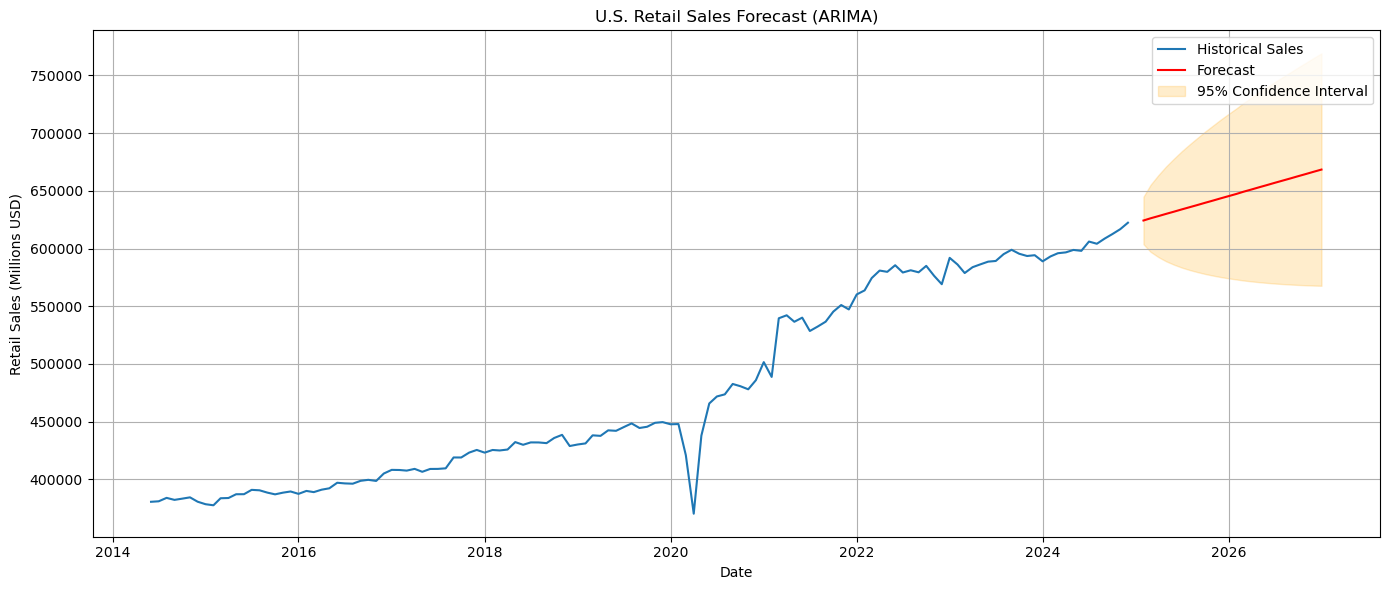

In [233]:
# Import Visual
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot historical retail sales
plt.plot(retail_sales['RSXFS'], label='Historical Sales')

# Plot forecast
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')

# Fill confidence interval
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'], 
                 color='orange', alpha=0.2, label='95% Confidence Interval')

plt.title('U.S. Retail Sales Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Retail Sales (Millions USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('financial_analyst_project/visualz/forecast_plot.png')
plt.show()

## Model Evaluation

To assess how well the ARIMA model performed, we use:
- **Residual analysis**
- **Root Mean Squared Error (RMSE)**

If we didn’t hold out test data, we explain why and note this as a future enhancement.

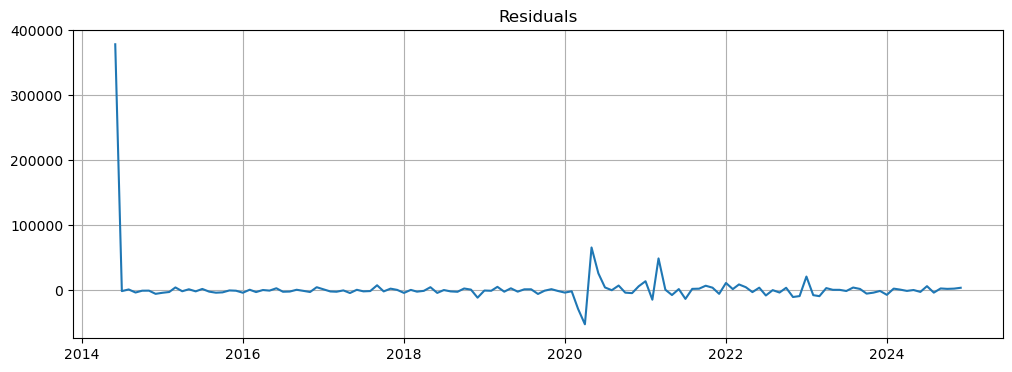

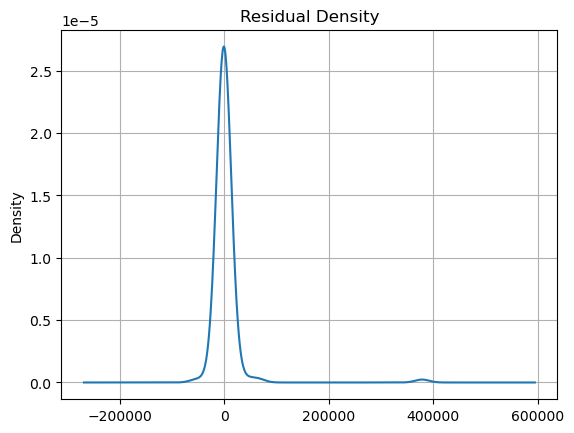

In-sample RMSE: 35189.94


In [234]:
from sklearn.metrics import mean_squared_error

residuals = model.resid()

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals")
plt.grid(True)
plt.show()

residuals.plot(kind='kde', title='Residual Density')
plt.grid(True)
plt.show()

rmse = np.sqrt(mean_squared_error(retail_sales['RSXFS'], model.predict_in_sample()))
print(f"In-sample RMSE: {rmse:.2f}")

## Insights & Business Takeaways  
- Model captured seasonality and long-term trend  
- Confidence intervals suggest stable forecast reliability  
- Forecasts can assist in financial planning and resource allocation  

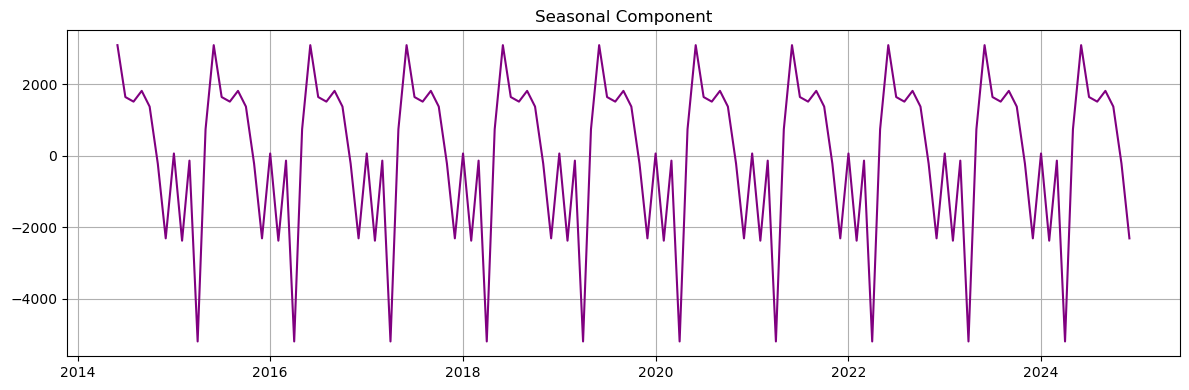

In [235]:
# Perform decomposition
decomp = seasonal_decompose(retail_sales['RSXFS'], model='additive', period=12)

# Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(decomp.seasonal, color='purple')
plt.title('Seasonal Component')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('financial_analyst_project/visualz/forecast_plot.png')
plt.show()

## Next Steps  
- Try SARIMA or Prophet to capture seasonality more explicitly  
- Build a Streamlit app for deployment  
- Add inflation or labor market data for multivariate forecasting 